# PCA 

The goal of the project is to use a dimension reduction approach (PCA, etc.) to decompose and transform high-dimension image data into a (much) lower dimension space for classification and clustering. The dataset can be found here: https://drive.google.com/drive/folders/1FcSHxEKHIyZ_Vckh6K1GDTN-VdM7tgD6 

For each subtask listed below, find the best two eigenvectors that define a 2D space to best separate corresponding categories, visualize individual data points in a 2D plot and calculate a Silhouette score
for each subtask. <br>

Subtask 1. Emotion recognition <br>
Subtask 2. Mask detection <br>
Subtask 3. Person identification <br>

Bonus points: Instead of using a whole image, you are encouraged to try other (creative) ways to solve each problem. A better solution should have a lower Silhouette score than the default one. Even if you may not be able to implement an idea you come up with, you will earn extra points by clearly describing a new idea and explaining in what ways it may improve performance. <br>

Write a report to explain your results and summarize what you’ve learned by trying to find the best dimension reduction solution for each problem.

# Contents
[Method 1: Grayscale image](#method1) <br>
[Method 2: Edges](#method2) <br>
[Method 3: Crop Image](#method3) <br>
[Report](#report) <br>


# Load data

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

results = pd.DataFrame()

In [2]:
data_dir = '/Users/mcmahonmc/Box/00 Fall 2021/Machine Learning/processed/'

img_files = sorted(glob.glob(data_dir + '*.jpg'))
print('We have %.f images total' % len(img_files))

We have 120 images total


In [3]:
data = pd.DataFrame({'person': [file.split('processed/')[1].split('_')[0] for file in img_files],
                     'emotion': [file.split('processed/')[1].split('_')[1] for file in img_files],
                     'mask': [file.split('processed/')[1].split('_')[2].split('.jpg')[0] for file in img_files]})

data['emotion'] = data['emotion'].replace(['A', 'H', 'N', 'S'], ['Angry', 'Happy', 'Neutral', 'Sad'])
data['mask'] = data['mask'].replace(['M', 'N'], ['Mask', 'No Mask'])

data

person  emotion     mask
0      AMR    Angry     Mask
1      AMR    Angry  No Mask
2      AMR    Happy     Mask
3      AMR    Happy  No Mask
4      AMR  Neutral     Mask
..     ...      ...      ...
115     ZM    Happy  No Mask
116     ZM  Neutral     Mask
117     ZM  Neutral  No Mask
118     ZM      Sad     Mask
119     ZM      Sad  No Mask

[120 rows x 3 columns]

(265, 200)


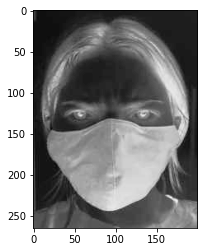

In [4]:
img0 = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
print(img0.shape)
plt.imshow(img0, cmap='Greys')

In [5]:
images = np.zeros((265,200))

for img_file in img_files:
    images = np.dstack((images, cv2.imread(img_file ,cv2.IMREAD_GRAYSCALE)))

images = images[:,:,1:]
images = np.transpose(images, (2, 0, 1))
n_samples, h, w = images.shape
print(images.shape)                

(120, 265, 200)


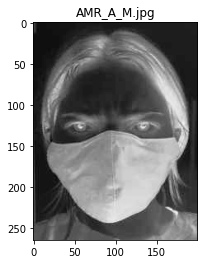

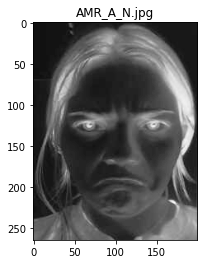

In [6]:
plt.imshow(images[0], cmap='Greys')
plt.title(img_files[0].split('processed/')[1])
plt.show()

plt.imshow(images[1], cmap='Greys')
plt.title(img_files[1].split('processed/')[1])
plt.show()

In [7]:
X = images.reshape((120,-1))
n_features = X.shape[1]

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Method 1: Grayscale Image <a id='method1'></a>

## Subtask 1. Emotion recognition

In [9]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  120
Size of a data sample:  53000
Number of Class Labels:  4


In [10]:
def plot_gallery(images, titles, h, w, n_samples=images.shape[0], n_col = 4):
    n_row = math.ceil(n_samples/n_col)
    plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom = 0, left =.01, right =.99, top =1, hspace =.55)
    for i in range(n_row * n_col):
        try:
            plt.subplot(n_row, n_col, i + 1)
            plt.imshow(images[i].reshape((h, w)), cmap = plt.cm.gray)
            plt.title(str(titles[i]).replace(' ', '\n'), size = 10)
            plt.xticks(()); plt.yticks(())
        except Exception as e:
            print(e)


In [11]:
titles = np.array(data)

plot_gallery(X, titles, h, w)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  90 and Testing Data is  30


In [13]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [14]:
np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]

15

In [15]:
# n_components = 14
n_components = 4

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Projecting the input data on the eigenfaces orthonormal basis


In [16]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         9
       Happy       0.00      0.00      0.00         8
     Neutral       0.19      0.43      0.26         7
         Sad       0.07      0.17      0.10         6

    accuracy                           0.13        30
   macro avg       0.06      0.15      0.09        30
weighted avg       0.06      0.13      0.08        30



In [17]:
X_test.shape[0]-1

29

index 30 is out of bounds for axis 0 with size 30
index 31 is out of bounds for axis 0 with size 30


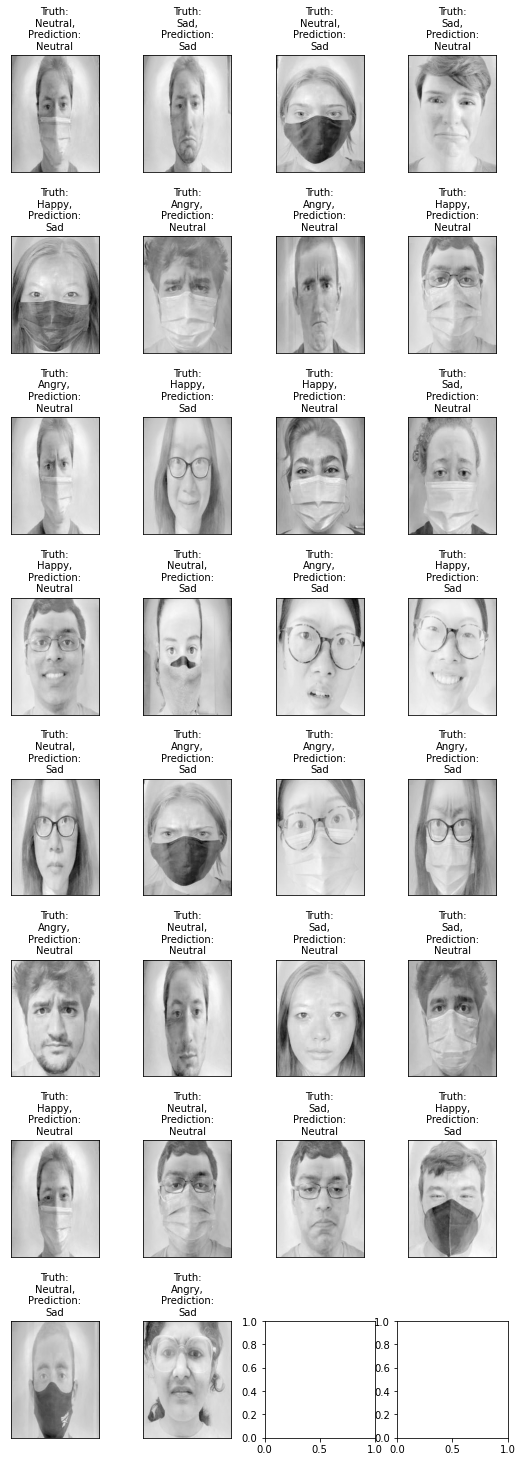

In [18]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0])

In [19]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [20]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y_test.values
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4  Cluster
0 -0.741280  0.255245 -0.206759 -1.213637  Neutral
1 -1.020742 -0.061987 -0.483117 -1.304114      Sad
2 -0.919049 -2.146619 -1.360740  0.687762  Neutral
3 -0.515649  0.663120  1.492769 -0.662821      Sad
4  0.490041 -1.138617 -1.005031 -0.505497    Happy

In [21]:
selection = np.argmin([metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']), 
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])])

print(list(['Eigen 1, Eigen 2', 'Eigen 1, Eigen 3', 'Eigen 1, Eigen 4', 'Eigen 2, Eigen 3',
       'Eigen 2, Eigen 4','Eigen 3, Eigen 4'])[selection])

print(selection)



Eigen 1, Eigen 2
0


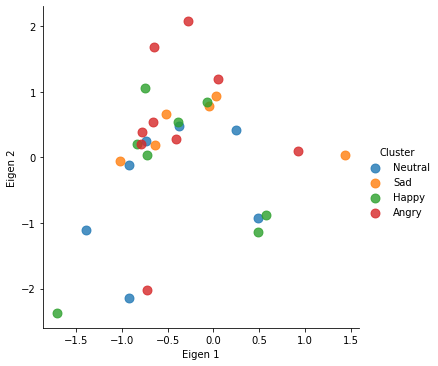

In [22]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [23]:
results = results.append({'subtask': 'emotion', 
                          'method': '1-raw', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']))

Silhouette Coefficient: -0.178


## Subtask 2. Mask recognition

In [24]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  120
Size of a data sample:  53000
Number of Class Labels:  2


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))

size of training Data is  90 and Testing Data is  30


In [26]:
pca = PCA().fit(X_train)

# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 4
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 4
Projecting the input data on the eigenfaces orthonormal basis


In [27]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.92      0.71      0.80        17
     No Mask       0.71      0.92      0.80        13

    accuracy                           0.80        30
   macro avg       0.81      0.81      0.80        30
weighted avg       0.83      0.80      0.80        30



In [28]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0])

index 30 is out of bounds for axis 0 with size 30
index 31 is out of bounds for axis 0 with size 30


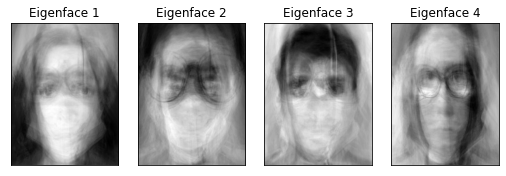

In [29]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

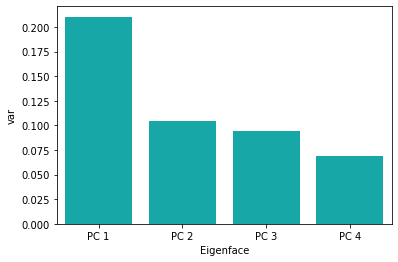

In [30]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [31]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y_test.values
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4  Cluster
0 -0.741280  0.255245 -0.206759 -1.213640     Mask
1 -1.020742 -0.061987 -0.483117 -1.304119  No Mask
2 -0.919049 -2.146619 -1.360740  0.687768     Mask
3 -0.515649  0.663120  1.492769 -0.662815  No Mask
4  0.490041 -1.138617 -1.005031 -0.505499     Mask

In [32]:
selection = np.argmin([metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']), 
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])])

print(list(['Eigen 1, Eigen 2', 'Eigen 1, Eigen 3', 'Eigen 1, Eigen 4', 'Eigen 2, Eigen 3',
       'Eigen 2, Eigen 4','Eigen 3, Eigen 4'])[selection])

print(selection)




Eigen 1, Eigen 3
1


In [33]:
sns.lmplot( x="Eigen 1", y="Eigen 3",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [34]:
results = results.append({'subtask': 'mask', 
                          'method': '1-raw', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']))

Silhouette Coefficient: -0.040


## Subtask 3. Person recognition

In [35]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)

Number of Data Samples:  120
Size of a data sample:  53000
Number of Class Labels:  15


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  90 and Testing Data is  30


In [37]:
pca = PCA().fit(X_train)

# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0] 
n_components = 4
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 4
Projecting the input data on the eigenfaces orthonormal basis


In [38]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       1.00      1.00      1.00         2
          AP       0.00      0.00      0.00         4
          AS       0.00      0.00      0.00         1
          DL       1.00      1.00      1.00         2
          EB       1.00      1.00      1.00         1
          ID       1.00      0.20      0.33         5
          MM       0.50      1.00      0.67         1
         MVM       0.17      1.00      0.29         1
          OD       0.33      0.67      0.44         3
          RO       0.50      0.50      0.50         2
          SZ       1.00      0.67      0.80         3
          UK       0.50      1.00      0.67         1
          WW       1.00      1.00      1.00         3
          ZM       1.00      1.00      1.00         1

    accuracy                           0.60        30
   macro avg       0.64      0.72      0.62        30
weighted avg       0.67      0.60      0.57        30



In [39]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

index 30 is out of bounds for axis 0 with size 30
index 31 is out of bounds for axis 0 with size 30


In [40]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

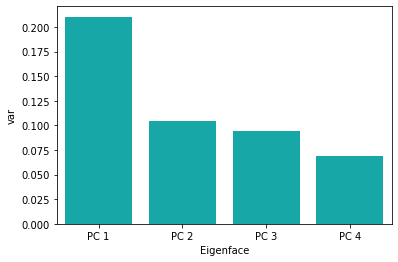

In [41]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [42]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y_test.values
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4 Cluster
0 -0.741280  0.255245 -0.206759 -1.213637      ID
1 -1.020742 -0.061987 -0.483117 -1.304116      ID
2 -0.919049 -2.146619 -1.360740  0.687762     AMR
3 -0.515649  0.663120  1.492770 -0.662818      MM
4  0.490041 -1.138617 -1.005031 -0.505498      DL

In [43]:
selection = np.argmin([metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']), 
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])])

print(list(['Eigen 1, Eigen 2', 'Eigen 1, Eigen 3', 'Eigen 1, Eigen 4', 'Eigen 2, Eigen 3',
       'Eigen 2, Eigen 4','Eigen 3, Eigen 4'])[selection])

print(selection)




Eigen 1, Eigen 2
0


In [44]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [45]:
results = results.append({'subtask': 'person', 
                          'method': '1-raw', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']))

Silhouette Coefficient: -0.127


# Method 2: Edges <a id='method2'></a>

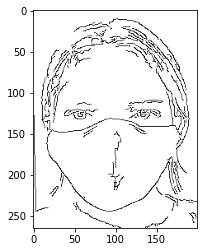

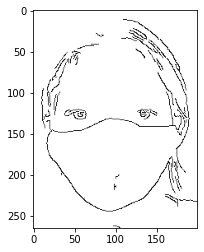

In [46]:
lower = [10, 30, 50]
upper = [50, 70, 100]

for l, u in zip(lower, upper):
    gray_image = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
    edged_image = cv2.Canny(gray_image, threshold1=l, threshold2=u)
    plt.imshow(edged_image, cmap = 'Greys')
    plt.show()

In [47]:
edged_images = np.zeros((265,200))

for img_file in img_files:
    gray_image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    edged_image = cv2.Canny(gray_image, threshold1=30, threshold2=70)
    edged_images = np.dstack((edged_images, edged_image))

edged_images = edged_images[:,:,1:]
edged_images = np.transpose(edged_images, (2, 0, 1))
n_samples, h, w = edged_images.shape
print(edged_images.shape)                

(120, 265, 200)


In [48]:
X = edged_images.reshape((120,-1))
n_features = X.shape[1]

In [49]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

## Subtask 1. Emotion recognition

In [50]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  120
Size of a data sample:  53000
Number of Class Labels:  4


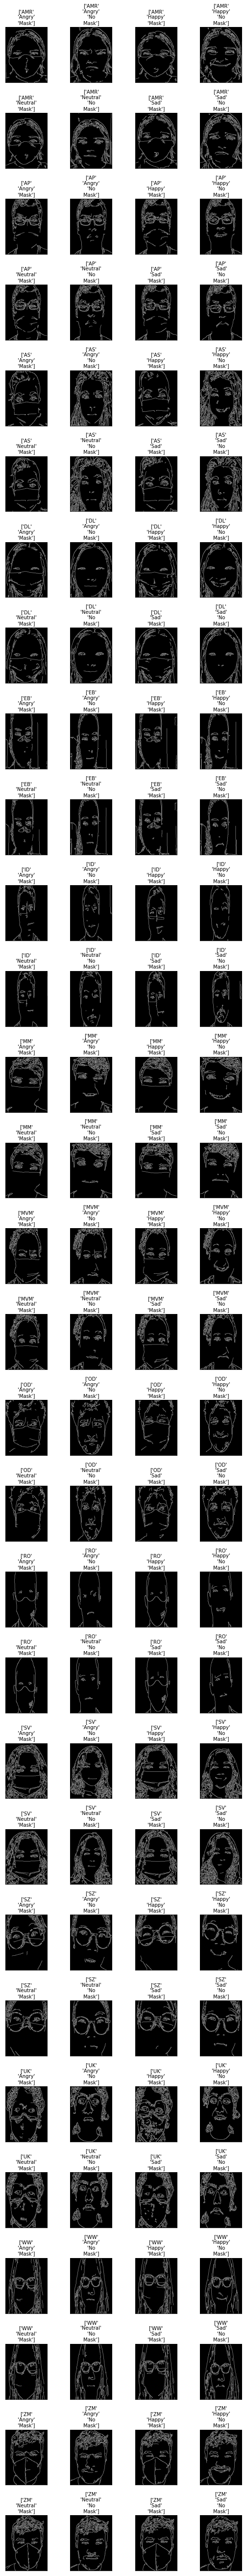

In [51]:
titles = np.array(data)
plot_gallery(X, titles, h, w)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  90 and Testing Data is  30


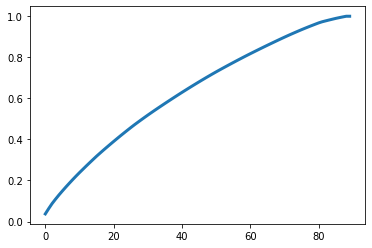

In [53]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [54]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 4
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 4
Projecting the input data on the eigenfaces orthonormal basis


In [55]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         9
       Happy       0.00      0.00      0.00         8
     Neutral       0.00      0.00      0.00         7
         Sad       0.12      0.50      0.19         6

    accuracy                           0.10        30
   macro avg       0.03      0.12      0.05        30
weighted avg       0.02      0.10      0.04        30



In [56]:
predictions

array(['Sad', 'Sad', 'Sad', 'Angry', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad',
       'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad',
       'Neutral', 'Sad', 'Sad', 'Sad', 'Angry', 'Sad', 'Sad', 'Sad',
       'Angry', 'Sad', 'Sad', 'Neutral'], dtype=object)

index 30 is out of bounds for axis 0 with size 30
index 31 is out of bounds for axis 0 with size 30


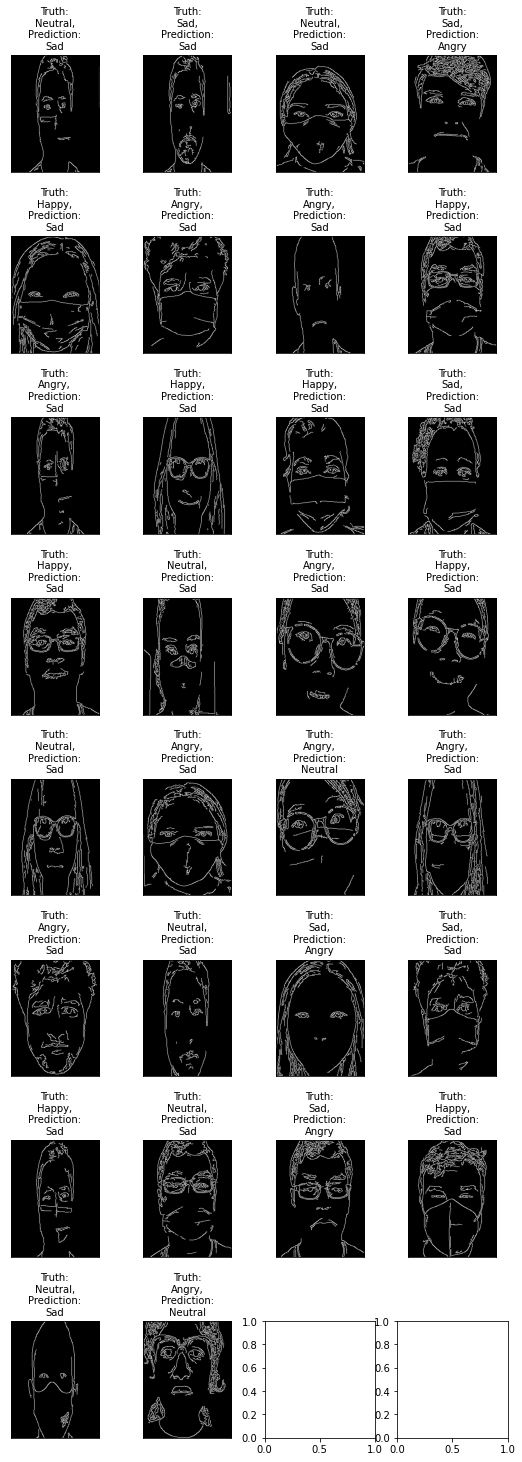

In [57]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

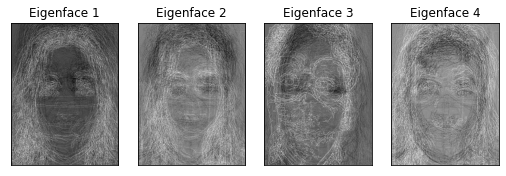

In [58]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

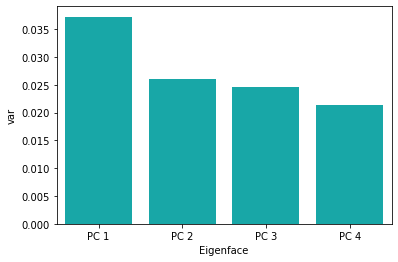

In [59]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [60]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y_test.values
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4  Cluster
0 -0.752156  0.499206 -0.287683 -0.027081  Neutral
1 -0.781715  0.553876 -0.255491 -0.048203      Sad
2  0.039399  0.275557 -0.088526 -0.355801  Neutral
3 -0.395128 -1.064727 -0.097380 -0.413897      Sad
4  0.331109  0.184416 -0.295531  0.389953    Happy

In [61]:
selection = np.argmin([metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']), 
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])])

print(list(['Eigen 1, Eigen 2', 'Eigen 1, Eigen 3', 'Eigen 1, Eigen 4', 'Eigen 2, Eigen 3',
       'Eigen 2, Eigen 4','Eigen 3, Eigen 4'])[selection])

print(selection)




Eigen 3, Eigen 4
5


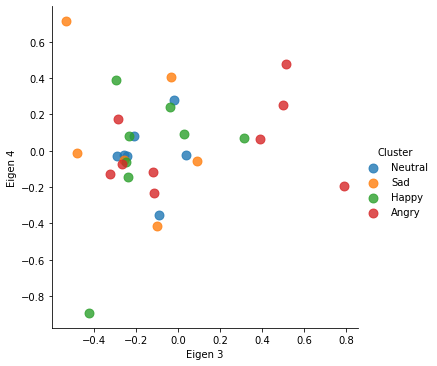

In [62]:
sns.lmplot( x="Eigen 3", y="Eigen 4",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [63]:
results = results.append({'subtask': 'emotion', 
                          'method': '2-edges', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster']))

Silhouette Coefficient: -0.167


## Subtask 2. Mask recognition

In [64]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  120
Size of a data sample:  53000
Number of Class Labels:  2


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  90 and Testing Data is  30


In [66]:
pca = PCA().fit(X_train)

In [67]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 4
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 4
Projecting the input data on the eigenfaces orthonormal basis


In [68]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.59      1.00      0.74        17
     No Mask       1.00      0.08      0.14        13

    accuracy                           0.60        30
   macro avg       0.79      0.54      0.44        30
weighted avg       0.77      0.60      0.48        30



In [69]:
predictions

array(['Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask',
       'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask',
       'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'No Mask', 'Mask',
       'Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'Mask'], dtype=object)

index 30 is out of bounds for axis 0 with size 30
index 31 is out of bounds for axis 0 with size 30


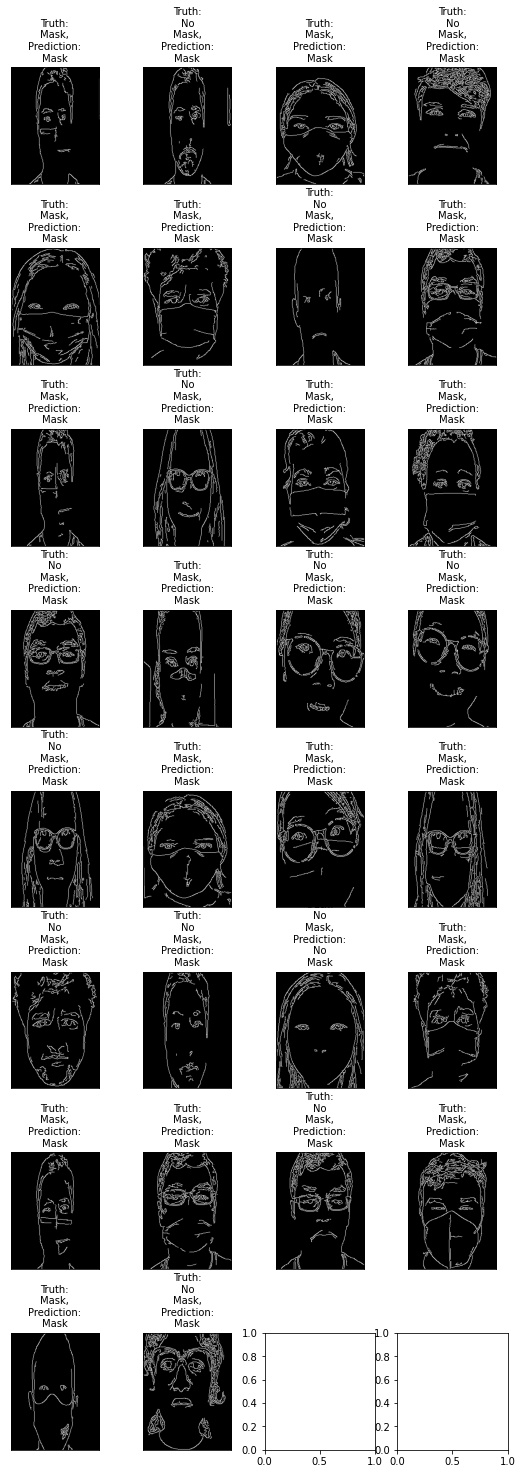

In [70]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

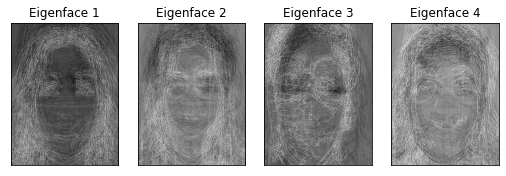

In [71]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

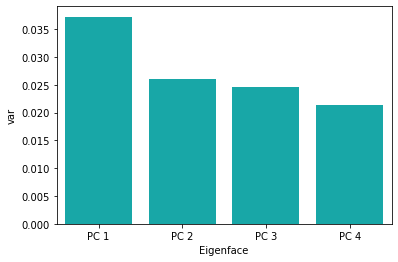

In [72]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [73]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y_test.values
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4  Cluster
0 -0.752133  0.498463 -0.283185 -0.027139     Mask
1 -0.781650  0.552606 -0.249664 -0.049546  No Mask
2  0.039200  0.272992 -0.073317 -0.360612     Mask
3 -0.394430 -1.070757 -0.099259 -0.400856  No Mask
4  0.331173  0.195961 -0.303079  0.351253     Mask

In [74]:
selection = np.argmin([metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']), 
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])])

print(list(['Eigen 1, Eigen 2', 'Eigen 1, Eigen 3', 'Eigen 1, Eigen 4', 'Eigen 2, Eigen 3',
       'Eigen 2, Eigen 4','Eigen 3, Eigen 4'])[selection])

print(selection)




Eigen 1, Eigen 4
2


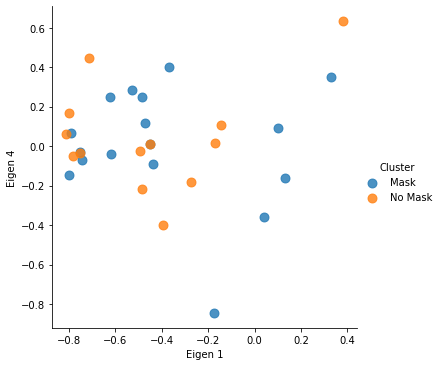

In [75]:
sns.lmplot( x="Eigen 1", y="Eigen 4",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [76]:
results = results.append({'subtask': 'mask', 
                          'method': '2-edges', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']))

Silhouette Coefficient: -0.040


## Subtask 3. Person recognition

In [77]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  120
Size of a data sample:  53000
Number of Class Labels:  15


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  90 and Testing Data is  30


In [79]:
pca = PCA().fit(X_train)

In [80]:
n_components = 4
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 4
Projecting the input data on the eigenfaces orthonormal basis


In [81]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       0.67      1.00      0.80         2
          AP       0.00      0.00      0.00         4
          AS       0.00      0.00      0.00         1
          DL       1.00      0.50      0.67         2
          EB       0.00      0.00      0.00         1
          ID       0.00      0.00      0.00         5
          MM       0.50      1.00      0.67         1
         MVM       0.20      1.00      0.33         1
          OD       0.67      0.67      0.67         3
          RO       0.20      1.00      0.33         2
          SZ       1.00      0.67      0.80         3
          UK       1.00      1.00      1.00         1
          WW       1.00      0.33      0.50         3
          ZM       0.00      0.00      0.00         1

    accuracy                           0.43        30
   macro avg       0.45      0.51      0.41        30
weighted avg       0.45      0.43      0.38        30



In [82]:
predictions

array(['RO', 'RO', 'AMR', 'MM', 'AMR', 'OD', 'RO', 'MVM', 'RO', 'EB',
       'RO', 'MVM', 'MVM', 'RO', 'SZ', 'OD', 'EB', 'AMR', 'SZ', 'WW',
       'OD', 'RO', 'DL', 'RO', 'RO', 'MVM', 'MVM', 'MM', 'RO', 'UK'],
      dtype=object)

index 30 is out of bounds for axis 0 with size 30
index 31 is out of bounds for axis 0 with size 30


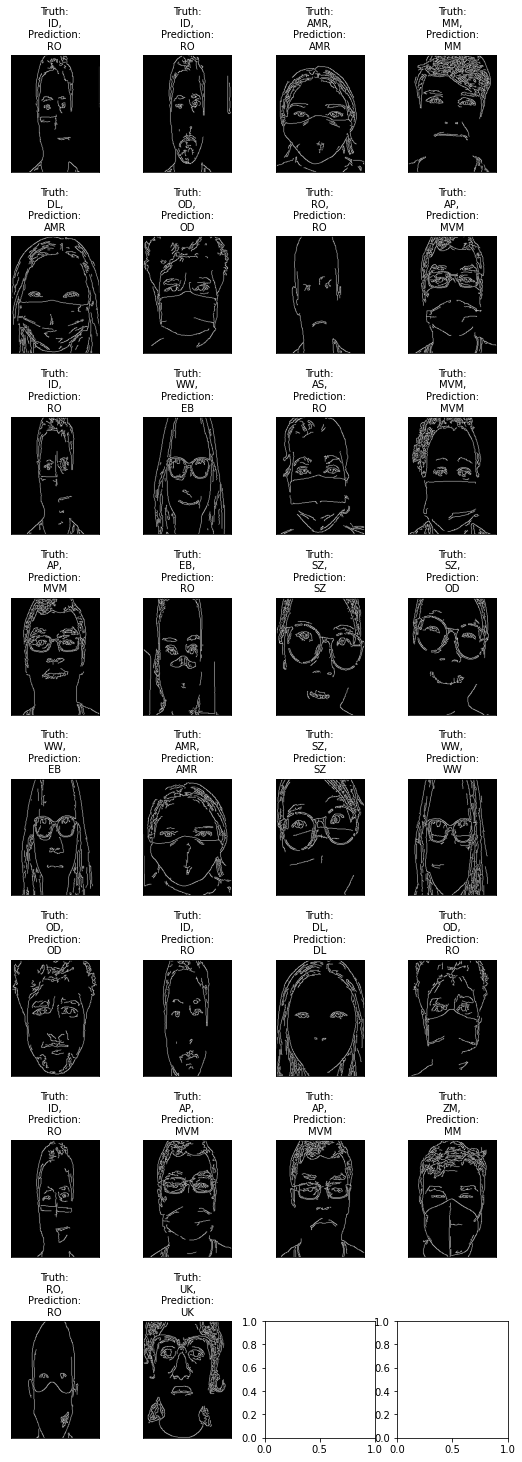

In [83]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

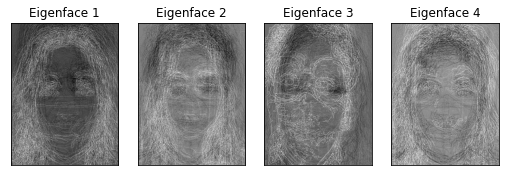

In [84]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

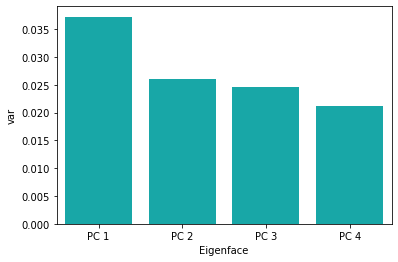

In [85]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [86]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y_test.values
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4 Cluster
0 -0.751996  0.496796 -0.278357 -0.074340      ID
1 -0.781443  0.548284 -0.233605 -0.096057      ID
2  0.038901  0.278290 -0.119700 -0.362232     AMR
3 -0.394187 -1.068857 -0.083384 -0.428301      MM
4  0.330881  0.187892 -0.311878  0.389954      DL

In [87]:
selection = np.argmin([metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']), 
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])])

print(list(['Eigen 1, Eigen 2', 'Eigen 1, Eigen 3', 'Eigen 1, Eigen 4', 'Eigen 2, Eigen 3',
       'Eigen 2, Eigen 4','Eigen 3, Eigen 4'])[selection])

print(selection)


Eigen 3, Eigen 4
5


In [88]:
sns.lmplot( x="Eigen 3", y="Eigen 4",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [89]:
results = results.append({'subtask': 'person', 
                          'method': '2-edges', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster']))

Silhouette Coefficient: -0.020


# Method 3: Crop <a id='method3'></a>

In [90]:
math.ceil(img0.shape[1]/2)

100

In [91]:
plt.imshow(img0[math.ceil(img0.shape[1]*(1/2)): math.ceil(img0.shape[1]*(2/3)),:])

In [92]:
scale1 = (1/3)
scale2 = (4/5)

cropped_images = np.zeros((265,200))
cropped_images = cropped_images[math.ceil(img0.shape[1]*scale1): math.ceil(img0.shape[1]*scale2),:]

for img_file in img_files:
    gray_image = cv2.imread(img_file, cv2.IMREAD_GRAYSCALE)
    cropped_image = gray_image[math.ceil(gray_image.shape[1]*scale1): math.ceil(gray_image.shape[1]*scale2),:]
    cropped_images = np.dstack((cropped_images, cropped_image))

cropped_images = cropped_images[:,:,1:]
cropped_images = np.transpose(cropped_images, (2, 0, 1))
n_samples, h, w = cropped_images.shape
print(cropped_images.shape)                

(120, 93, 200)


In [93]:
X = cropped_images.reshape((120,-1))
n_features = X.shape[1]
print(X.shape)

(120, 18600)


In [94]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

## Subtask 1. Emotion recognition

In [95]:
y = data['emotion']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  120
Size of a data sample:  18600
Number of Class Labels:  4


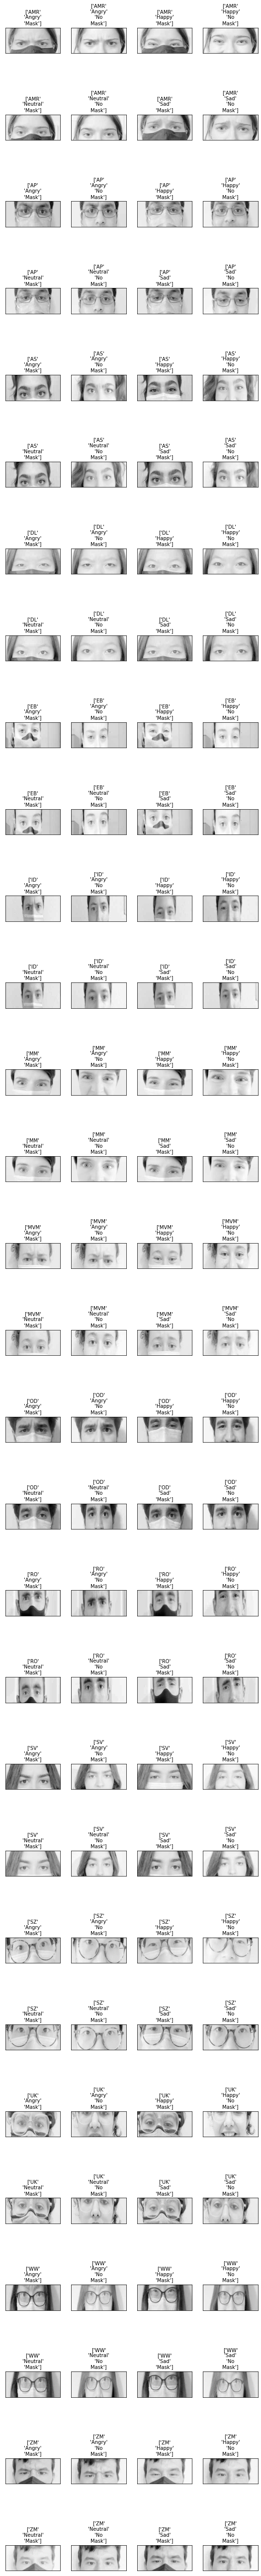

In [96]:
titles = np.array(data)
plot_gallery(X, titles, h, w)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  90 and Testing Data is  30


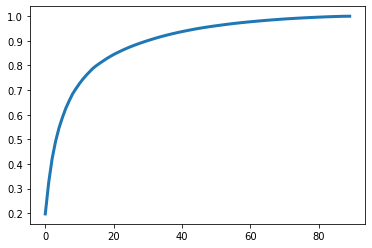

In [98]:
pca = PCA().fit(X_train)

plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [99]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 4
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 4
Projecting the input data on the eigenfaces orthonormal basis


In [100]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

       Angry       0.00      0.00      0.00         9
       Happy       0.20      0.12      0.15         8
     Neutral       0.17      0.29      0.21         7
         Sad       0.00      0.00      0.00         6

    accuracy                           0.10        30
   macro avg       0.09      0.10      0.09        30
weighted avg       0.09      0.10      0.09        30



In [101]:
predictions

array(['Happy', 'Happy', 'Neutral', 'Neutral', 'Angry', 'Neutral',
       'Happy', 'Neutral', 'Happy', 'Sad', 'Neutral', 'Neutral',
       'Neutral', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad', 'Sad',
       'Neutral', 'Neutral', 'Angry', 'Neutral', 'Happy', 'Sad',
       'Neutral', 'Angry', 'Sad', 'Neutral'], dtype=object)

index 30 is out of bounds for axis 0 with size 30
index 31 is out of bounds for axis 0 with size 30


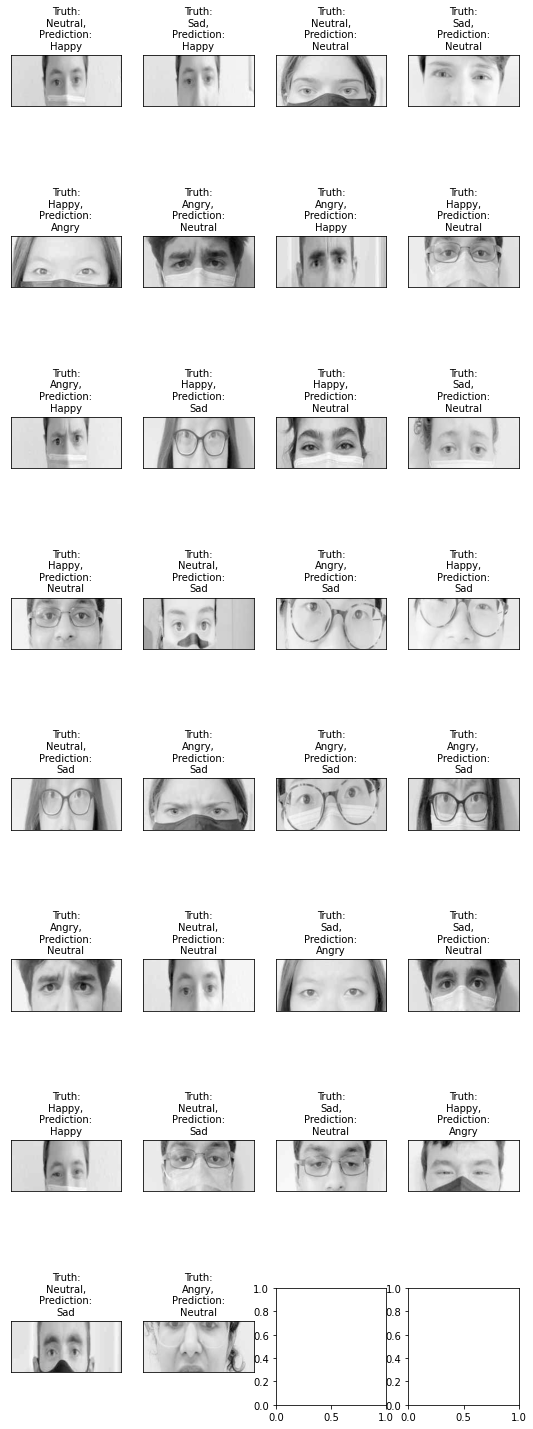

In [102]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

In [103]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

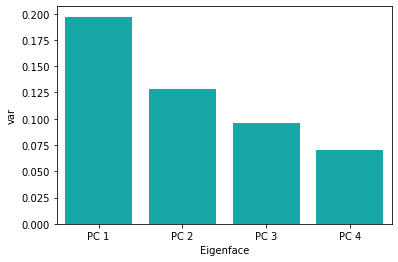

In [104]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [105]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y_test.values
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4  Cluster
0 -1.382862  0.494853 -0.492730 -0.325490  Neutral
1 -1.501470  0.582312 -0.526736 -0.296561      Sad
2 -0.056952 -0.104673  0.659428 -0.319011  Neutral
3 -0.471082  0.200119  0.761229  1.109075      Sad
4  0.326602  1.856757 -0.387465 -0.283152    Happy

In [106]:
selection = np.argmin([metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']), 
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])])

print(list(['Eigen 1, Eigen 2', 'Eigen 1, Eigen 3', 'Eigen 1, Eigen 4', 'Eigen 2, Eigen 3',
       'Eigen 2, Eigen 4','Eigen 3, Eigen 4'])[selection])

print(selection)




Eigen 2, Eigen 4
4


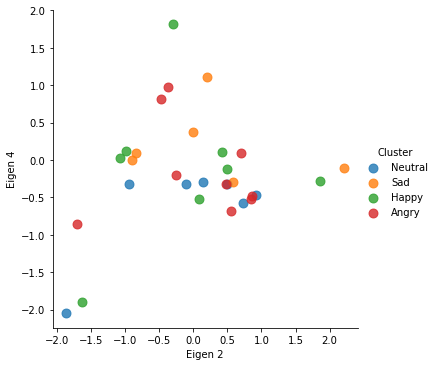

In [107]:
sns.lmplot( x="Eigen 2", y="Eigen 4",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [108]:
results = results.append({'subtask': 'emotion', 
                          'method': '3-crop', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']))

Silhouette Coefficient: -0.151


## Subtask 2. Mask recognition

In [109]:
y = data['mask']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  120
Size of a data sample:  18600
Number of Class Labels:  2


In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  90 and Testing Data is  30


In [111]:
pca = PCA().fit(X_train)

In [112]:
# n_components = np.where([pca.explained_variance_ratio_.cumsum() > .80])[1][0]
n_components = 4
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 4
Projecting the input data on the eigenfaces orthonormal basis


In [113]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        Mask       0.62      0.59      0.61        17
     No Mask       0.50      0.54      0.52        13

    accuracy                           0.57        30
   macro avg       0.56      0.56      0.56        30
weighted avg       0.57      0.57      0.57        30



In [114]:
predictions

array(['No Mask', 'No Mask', 'Mask', 'Mask', 'Mask', 'Mask', 'No Mask',
       'Mask', 'No Mask', 'No Mask', 'Mask', 'No Mask', 'Mask', 'Mask',
       'Mask', 'Mask', 'No Mask', 'Mask', 'Mask', 'Mask', 'Mask',
       'No Mask', 'No Mask', 'Mask', 'No Mask', 'No Mask', 'Mask',
       'No Mask', 'No Mask', 'No Mask'], dtype=object)

index 30 is out of bounds for axis 0 with size 30
index 31 is out of bounds for axis 0 with size 30


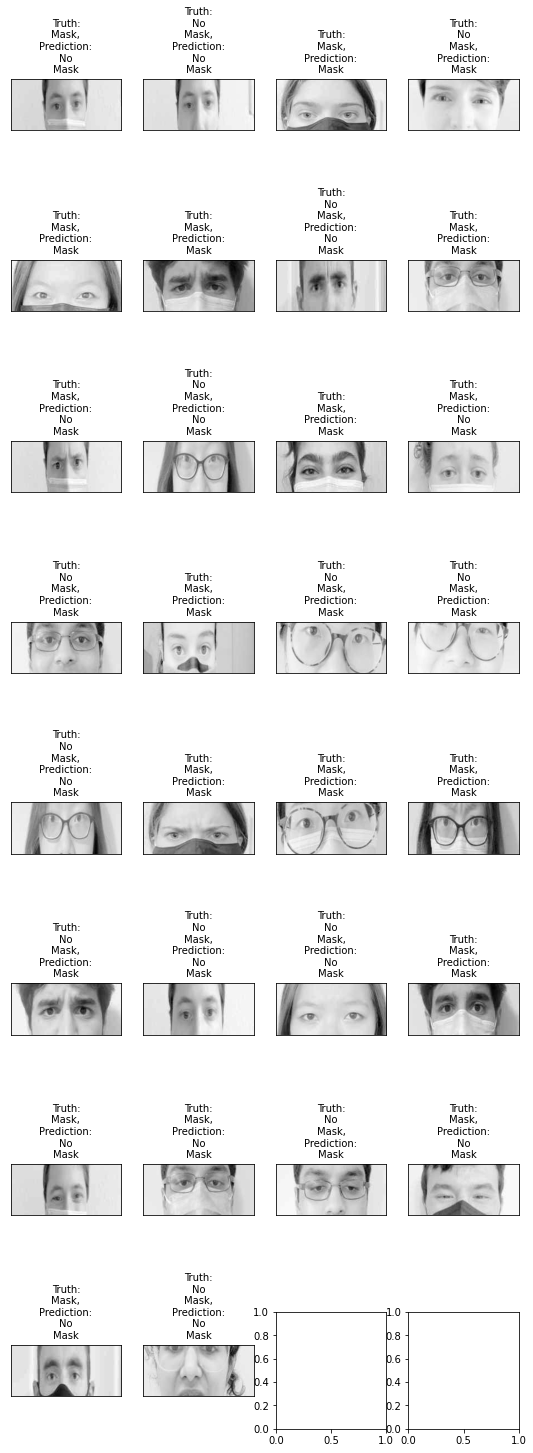

In [115]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

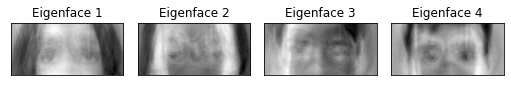

In [116]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

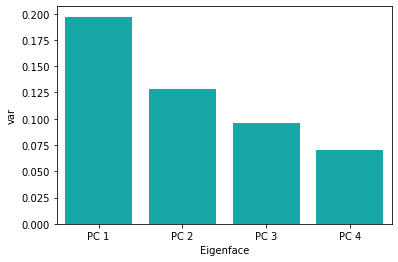

In [117]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [118]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y_test.values
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4  Cluster
0 -1.382862  0.494853 -0.492730 -0.325489     Mask
1 -1.501470  0.582312 -0.526736 -0.296558  No Mask
2 -0.056952 -0.104673  0.659429 -0.319004     Mask
3 -0.471082  0.200119  0.761229  1.109079  No Mask
4  0.326602  1.856757 -0.387465 -0.283155     Mask

In [119]:
selection = np.argmin([metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']), 
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])])

print(list(['Eigen 1, Eigen 2', 'Eigen 1, Eigen 3', 'Eigen 1, Eigen 4', 'Eigen 2, Eigen 3',
       'Eigen 2, Eigen 4','Eigen 3, Eigen 4'])[selection])

print(selection)




Eigen 1, Eigen 2
0


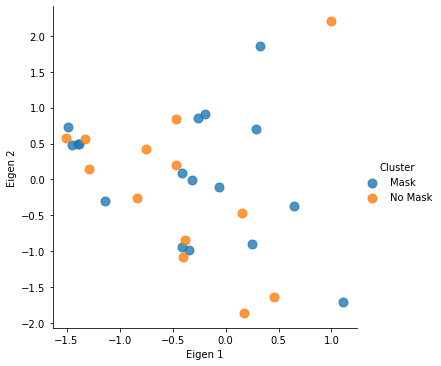

In [120]:
sns.lmplot( x="Eigen 1", y="Eigen 2",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

In [121]:
results = results.append({'subtask': 'mask', 
                          'method': '3-crop', 
                          'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']))

Silhouette Coefficient: -0.032


## Subtask 3. Person recognition

In [122]:
y = data['person']
target_names = np.unique(y)
n_classes = target_names.shape[0]

# Print Details about dataset
print("Number of Data Samples: % d" % n_samples)
print("Size of a data sample: % d" % n_features)
print("Number of Class Labels: % d" % n_classes)


Number of Data Samples:  120
Size of a data sample:  18600
Number of Class Labels:  15


In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print("size of training Data is % d and Testing Data is % d" %(y_train.shape[0], y_test.shape[0]))



size of training Data is  90 and Testing Data is  30


In [124]:
pca = PCA().fit(X_train)

In [125]:
n_components = 4
print('Number of components: %s' % n_components)

pca = PCA(n_components = n_components, svd_solver ='randomized', whiten = True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


Number of components: 4
Projecting the input data on the eigenfaces orthonormal basis


In [126]:
classifer = SVC().fit(X_train_pca, y_train)

predictions = classifer.predict(X_test_pca)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         AMR       1.00      0.50      0.67         2
          AP       1.00      0.50      0.67         4
          AS       1.00      1.00      1.00         1
          DL       1.00      1.00      1.00         2
          EB       1.00      1.00      1.00         1
          ID       0.00      0.00      0.00         5
          MM       0.00      0.00      0.00         1
         MVM       1.00      1.00      1.00         1
          OD       0.60      1.00      0.75         3
          RO       0.29      1.00      0.44         2
          SZ       1.00      0.67      0.80         3
          UK       0.25      1.00      0.40         1
          WW       1.00      1.00      1.00         3
          ZM       1.00      1.00      1.00         1

    accuracy                           0.67        30
   macro avg       0.72      0.76      0.69        30
weighted avg       0.69      0.67      0.63        30



In [127]:
predictions

array(['RO', 'RO', 'UK', 'UK', 'DL', 'OD', 'RO', 'OD', 'RO', 'WW', 'AS',
       'MVM', 'OD', 'EB', 'SZ', 'UK', 'WW', 'AMR', 'SZ', 'WW', 'OD', 'RO',
       'DL', 'OD', 'RO', 'AP', 'AP', 'ZM', 'RO', 'UK'], dtype=object)

index 30 is out of bounds for axis 0 with size 30
index 31 is out of bounds for axis 0 with size 30


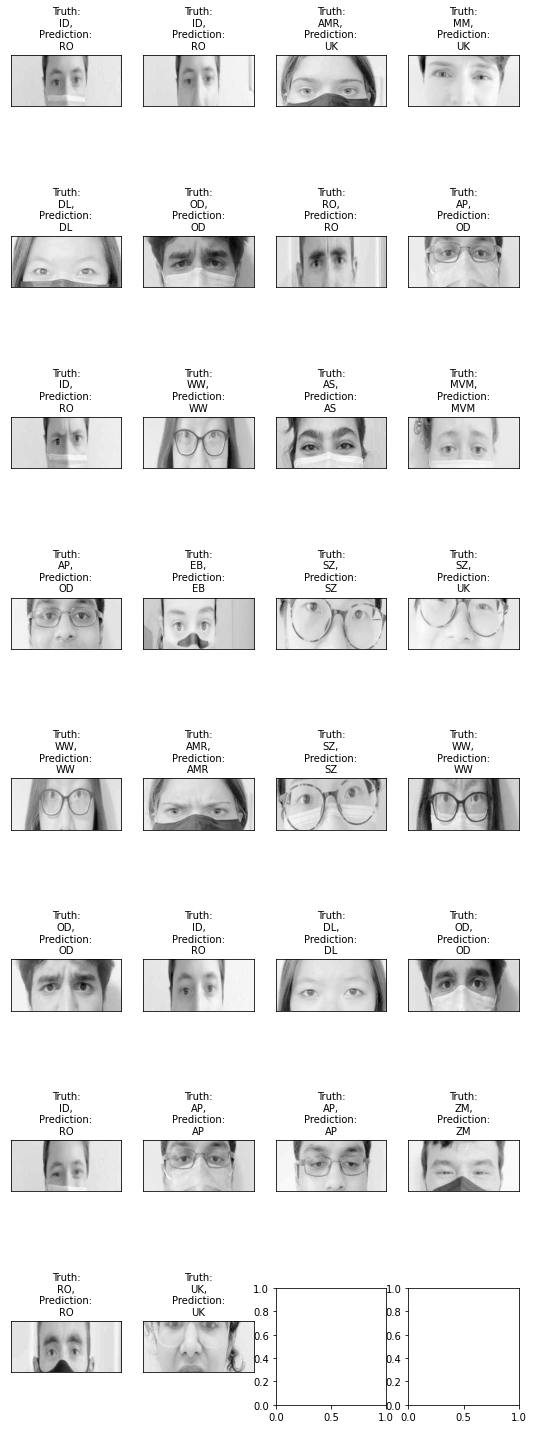

In [128]:
titles = ['Truth: %s, Prediction: %s' % (y_test_, predictions_) for y_test_, predictions_ in zip(y_test, predictions)]

plot_gallery(X_test, titles, h, w, n_samples=X_test.shape[0]-1)

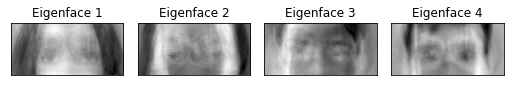

In [129]:
i=0
n_row = 1
n_col = len(eigenfaces)
plt.figure(figsize =(1.8 * n_col, 2.4 * n_row))
for eigenface in eigenfaces:
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(eigenface.reshape((h,w)), cmap = plt.cm.gray)
    plt.title('Eigenface %s' % str(i+1))
    plt.xticks(()); plt.yticks(())
    i +=1

plt.tight_layout()

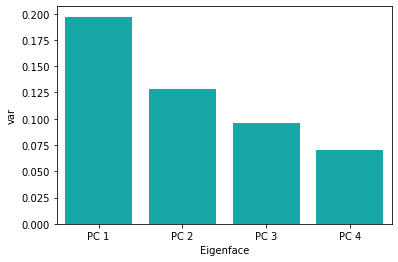

In [130]:
df = pd.DataFrame({'var':pca.explained_variance_ratio_,
             'Eigenface': ['PC ' + str(i+1) for i in range(0, len(eigenfaces))]})

sns.barplot(x='Eigenface',y="var", data=df, color="c");

In [131]:
pc_df = pd.DataFrame(data = X_test_pca , 
        columns = ['Eigen ' + str(i+1) for i in range(0, len(eigenfaces))])
pc_df['Cluster'] = y_test.values
pc_df.head()

Eigen 1   Eigen 2   Eigen 3   Eigen 4 Cluster
0 -1.382862  0.494853 -0.492730 -0.325489      ID
1 -1.501470  0.582312 -0.526736 -0.296560      ID
2 -0.056952 -0.104673  0.659429 -0.319012     AMR
3 -0.471082  0.200119  0.761230  1.109074      MM
4  0.326602  1.856757 -0.387465 -0.283153      DL

In [132]:
y_test.values

array(['ID', 'ID', 'AMR', 'MM', 'DL', 'OD', 'RO', 'AP', 'ID', 'WW', 'AS',
       'MVM', 'AP', 'EB', 'SZ', 'SZ', 'WW', 'AMR', 'SZ', 'WW', 'OD', 'ID',
       'DL', 'OD', 'ID', 'AP', 'AP', 'ZM', 'RO', 'UK'], dtype=object)

In [133]:
selection = np.argmin([metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster']), 
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 3']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 2', 'Eigen 4']], pc_df['Cluster']),
metrics.silhouette_score(pc_df[['Eigen 3', 'Eigen 4']], pc_df['Cluster'])])

print(list(['Eigen 1, Eigen 2', 'Eigen 1, Eigen 3', 'Eigen 1, Eigen 4', 'Eigen 2, Eigen 3',
       'Eigen 2, Eigen 4','Eigen 3, Eigen 4'])[selection])

print(selection)


Eigen 1, Eigen 3
1


Silhouette Coefficient: 0.024


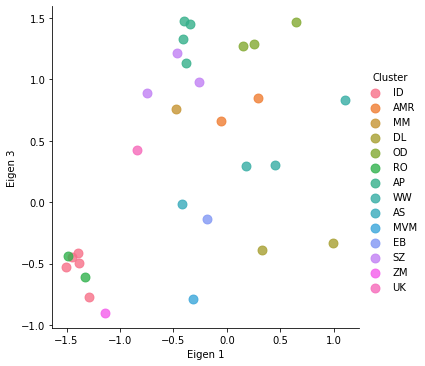

In [134]:
sns.lmplot( x="Eigen 1", y="Eigen 3",
  data=pc_df, 
  fit_reg=False, 
  hue='Cluster', # color by cluster
  legend=True,
  scatter_kws={"s": 80}) # specify the point size

results = results.append({'subtask': 'person', 
                      'method': '3-crop', 
                      'silhouette_score': metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster'])}, ignore_index=True)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 3']], pc_df['Cluster']))



In [135]:
metrics.silhouette_score(pc_df[['Eigen 1', 'Eigen 2']], pc_df['Cluster'])

0.14499136170255716

# Report <a id='report'></a>

For this assignment, I used PCA to decompose the face images. I split the images into test and training sets because I wanted to train a classifier to predict the label for each subtask: emotion, mask, and person. I tried finding the optimal number of components to use to reach 80% accuracy, but decided instead that I wanted to keep the number of components the same to be able to compare each of the image preprocessing methods easier. Alternately, I could have selected the number of components to optimize each method. I used the silhouette score to evaluate PCA performance after three preprocessing alternatives:

1) raw grayscale images <br>
2) image edges <br>
3) cropped images (focusing on eye to lip area) <br>

The silhouette score is a performance measures which accounts for both the distance between points within a cluster and the distance between clusters. Here, this score was calculated based on the only the two eigenvectors that minimized the silhouette score. These were plotted to visualize how well these two components were able to separate clusters according to their true labels. I could have shown this for the training points as well, but chose to keep the majority of the data visible here. I am only reporting the minimum silhouette score here to simiplify the tables.

I plotted the eigenfaces after decomposition of the data for each subtask. Certain combinations of eigenfaces yielded better silhouette scores than others across the tasks, which can be seen in the tables below.

**Emotion**

For the emotion subtask, the silhouette score was lowest when PCA was applied on the grayscale images. Edges images yielded the second best performance, with cropped images yielding the worst performance. This suggests that the algorithm was best able to make use of the full grayscale image in order to provide information about the emotion. It could be that a different edge threshold would have produced better results. Several edge thresholds were piloted, and I selected the one that I thought conveyed useful information but minimized extraneous information. It could be that the algorithm has a different idea about what constitutes useful information. Along these lines, the cropped image performed worst because it cut information that was useful to capture the variance in emotion labels in the dataset.


In [140]:
results['eigens'] = ['1,2', '1,3', '1,2', '3,4', '1,4', '3,4', '2,4', '1,2', '1,3']

In [141]:
results[results['subtask'] == 'emotion'].sort_values(['silhouette_score'], ascending=True)

subtask   method  silhouette_score eigens
0  emotion    1-raw         -0.178196    1,2
3  emotion  2-edges         -0.167204    3,4
6  emotion   3-crop         -0.150832    2,4

**Mask**

For the mask classification, the raw images yielded the best performance, followed by edges images, followed by the cropped images. While I thought cropping the image might help with emotion classification, it is unsurprising to me that the cropped method performed best because in many of the cases, a lot of the mask weas removed from the image. But perhaps the removed pixels also contained information that made it more difficult for the algorithm to determine whether there was a mask.

In [142]:
results[results['subtask'] == 'mask'].sort_values(['silhouette_score'], ascending=True)

subtask   method  silhouette_score eigens
1    mask    1-raw         -0.040274    1,3
4    mask  2-edges         -0.039585    1,4
7    mask   3-crop         -0.032239    1,2

**Person**

Similar results were obtained for the person identification, whereby cropped images performed best, followed by raw, followed by edges. This means that it was more beneficial to not have information about the person's clothing in order to classify the images by initials in this dataset. This suggests that here the edges were again unable to convey more useful information that maximized the separation of clusters resulting from the variance captured by the first two eigenvectors.

In [143]:
results[results['subtask'] == 'person'].sort_values(['silhouette_score'], ascending=True)

subtask   method  silhouette_score eigens
2  person    1-raw         -0.126885    1,2
5  person  2-edges         -0.020405    3,4
8  person   3-crop          0.024428    1,3

In addition to using the silhouette score, I also fed the PCA results to a SVM classifier and used that to give predictive labels to images in the training dataset. With SVM, edges images yielded the highest classification accuracy for both the emotion and mask subtask, followed by cropped images, followed by raw. On the person subtask, the cropped images yielded the best performance followed by the edges images. 

Because the SVM algorithm was trained on all the PCA components, not just the two principal components, it is possible that this additional information in the third and fourth component were better able to capture the variance in outcome. 

# References

[Sandipanweb Eigenfaces Tutorial](https://sandipanweb.wordpress.com/2018/01/06/eigenfaces-and-a-simple-face-detector-with-pca-svd-in-python/)